In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

import time

In [4]:
df_digest_protein = pd.read_csv('data/uniprot/df_digest_protein.csv')

In [5]:
print(df_digest_protein.shape)
df_digest_protein.head(1)

(5853, 5)


,PROTEIN,SEQUENCE,PROTEIN_FULL,SPECTRAL_CNT,SPECTRAL_CNT_MISS
0,sp|Q9NP61|ARFG3_HUMAN,MGDPSKQDILTIFKRLRSVPTNKVCFDCGAKNPSWASITYGVFLCI...,>sp|Q9NP61|ARFG3_HUMAN ADP-ribosylation factor...,M_2;G_206;D_0;P_5;S_0;K_0;Q_7;D_3;I_3;L_3;T_3;...,M_2;G_208;D_208;P_213;S_213;K_213;Q_217;D_217;...


# Digestibility Modeling
  - labelling followed AP3 paper

In [18]:
def labelling_ap3(prot2cnt, prot2cnt_miss, THRESHOLD = 4):  # prot2cnt, prot2cnt_miss must be list split by ;

    ts2label = dict()
    # protein loop
    for idx in range(len(prot2cnt)):
        # amino acid loop in one protein
        for amino_idx in range(len(prot2cnt[idx])):
            # tryptic site : K, R
            if prot2cnt[idx][amino_idx][:1] in 'KR':
                
                # *******TRYPTIC SITE EXTRACTING FROM PROTEIN*******
                # tryptic site in protein N-terminal
                if amino_idx <= THRESHOLD - 1:
                    tryptic_site = 'Z'*(THRESHOLD-amino_idx) + ''.join([a[0] for a in prot2cnt[idx][: amino_idx+THRESHOLD + 1]])  # added Z
                # tryptic site in protein C-terminal
                elif amino_idx >= len(prot2cnt[idx]) - THRESHOLD:
                    tryptic_site = ''.join([a[0] for a in prot2cnt[idx][amino_idx-THRESHOLD: amino_idx+THRESHOLD + 1]]) + 'Z'*(THRESHOLD-(len(prot2cnt[idx])-1)+amino_idx)  # added Z
                else:
                    tryptic_site = ''.join([a[0] for a in prot2cnt[idx][amino_idx-THRESHOLD: amino_idx+THRESHOLD + 1]])

                    
                # *******TRYPTIC SITE LABELLING (WHEN POSITIVE)*******
                # N-terminal of tryptic site condition
                N_condition = int(prot2cnt[idx][amino_idx][2:])
                # C-terminal of tryptic site condition
                if amino_idx == len(prot2cnt[idx]) - 1:  # tryptic site in last position of protein
                    C_condition = 0
                else:
                    C_condition = int(prot2cnt[idx][amino_idx + 1][2:])
                # miss cleavage of tryptic site contidion
                miss_condition = int(prot2cnt_miss[idx][amino_idx][2:])
                
                if (miss_condition + max(N_condition, C_condition))==0:
                    continue  # skip this tryptic site, because this site not yet detected.
                else:
                    condition = max(N_condition, C_condition) / (miss_condition + max(N_condition, C_condition))

                # *******MAKING DATASET*******
                if tryptic_site not in ts2label:
                    ts2label[tryptic_site] = []
                ts2label[tryptic_site].append((str(idx)+'_'+str(amino_idx), condition))
    return ts2label

In [8]:
prot2cnt = [_.split(';') for _ in df_digest_protein.SPECTRAL_CNT.values]
prot2cnt_miss = [_.split(';') for _ in df_digest_protein.SPECTRAL_CNT_MISS.values]

In [19]:
ts2label = labelling_ap3(prot2cnt, prot2cnt_miss, THRESHOLD=7)  # ts2label is just for checking

In [24]:
sorted(ts2label.items(), key=lambda x: len(x[1]), reverse=True)  # for EDA, digestibility check up !

[('VTSAPDTRPAPGSTA',
  [('2760_144', 1.0),
   ('2760_164', 1.0),
   ('2760_184', 1.0),
   ('2760_204', 1.0),
   ('2760_224', 1.0),
   ('2760_244', 1.0),
   ('2760_264', 1.0),
   ('2760_284', 1.0),
   ('2760_304', 1.0),
   ('2760_324', 1.0),
   ('2760_344', 1.0),
   ('2760_364', 1.0),
   ('2760_384', 1.0),
   ('2760_404', 1.0),
   ('2760_424', 1.0),
   ('2760_444', 1.0),
   ('2760_464', 1.0),
   ('2760_484', 1.0),
   ('2760_504', 1.0),
   ('2760_524', 1.0),
   ('2760_544', 1.0),
   ('2760_564', 1.0),
   ('2760_584', 1.0),
   ('2760_604', 1.0),
   ('2760_624', 1.0),
   ('2760_644', 1.0),
   ('2760_664', 1.0),
   ('2760_684', 1.0),
   ('2760_704', 1.0),
   ('2760_724', 1.0),
   ('2760_744', 1.0),
   ('2760_764', 1.0),
   ('2760_784', 1.0),
   ('2760_804', 1.0),
   ('2760_824', 1.0),
   ('2760_844', 1.0),
   ('2760_864', 1.0),
   ('2760_884', 1.0),
   ('2760_904', 1.0),
   ('2760_924', 1.0)]),
 ('TAKDSKFKMPKFKMP',
  [('2664_833', 0.0),
   ('2664_998', 0.0),
   ('2664_1328', 0.0),
   ('2664

In [25]:
for ts, prot2ratio in ts2label.items():
    ratio_arr = [_[1] for _ in prot2ratio]
    ratio = round(sum(ratio_arr) / len(ratio_arr), 2)
    ts2label[ts] = ratio

* train digestibility model

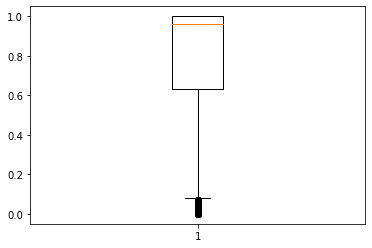

In [34]:
plt.boxplot(list(ts2label.values()))
plt.show()

In [33]:
y = list(ts2label.values())
for thres in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]:
    p = [_ for _ in y if _ >=thres]
    n = [_ for _ in y if _ < thres]
    print('thres : {}, P : {:,}, N : {:,}\n'.format(thres, len(p), len(n)))

thres : 0.1, P : 266,268, N : 19,999

thres : 0.2, P : 261,612, N : 24,655

thres : 0.3, P : 255,995, N : 30,272

thres : 0.4, P : 249,274, N : 36,993

thres : 0.5, P : 240,368, N : 45,899

thres : 0.6, P : 219,440, N : 66,827

thres : 0.7, P : 204,415, N : 81,852

thres : 0.8, P : 188,397, N : 97,870

thres : 0.85, P : 178,068, N : 108,199

thres : 0.9, P : 165,770, N : 120,497

thres : 0.95, P : 148,585, N : 137,682



In [38]:
def label_y(y_arr, THRES):
    return [1 if _ >= THRES else 0 for _ in y_arr]

In [41]:
def onehot_enc(aa):
    return [1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ']

In [39]:
THRES = 0.8
df_digest = pd.DataFrame({'tryptic_site':list(ts2label.keys()), 'label':label_y(list(ts2label.values()), THRES)})

In [42]:
X = np.array([[__ for _ in ts for __ in onehot_enc(_)] for ts in df_digest.tryptic_site.values])
y = df_digest.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, random_state=77)
print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)
RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_digest.fit(X_train, y_train)

(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)


RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [43]:
y_pred = RF_digest.predict(X_test)
print(classification_report(y_test, y_pred))
probs = RF_digest.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, probs)
print('AUC : {}'.format(rf_auc))

              precision    recall  f1-score   support

           0       0.78      0.50      0.61     24336
           1       0.78      0.93      0.85     47231

    accuracy                           0.78     71567
   macro avg       0.78      0.71      0.73     71567
weighted avg       0.78      0.78      0.77     71567

AUC : 0.8338532458275664


In [44]:
RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_digest.fit(X, y)  # for adjusting Detectability

RandomForestClassifier(max_features='sqrt', n_estimators=200)

# Detectability

In [51]:
def cal_digestibility(seq_li, model):
    noseq_idx = [idx for idx, _ in enumerate(seq_li) if _ == '-']
    X = np.array([[__ for _ in seq for __ in onehot_enc(_)] if seq != '-' else [0]*315 for seq in seq_li])
    y_pred = model.predict_proba(X)[:, 1]  # positive probability = digestibility
    y_pred[noseq_idx] = 1
    return y_pred

In [49]:
def labelling_detect(df, aa2val, RF_digest):
    # set tryptic site 9mer
    df['miss'] = [sum([1 for _ in p[:-1] if _ in 'KR']) for p in df.PEP.values]
#     df['En'] = df.En.apply(lambda x: x[3:-3]).values
#     df['Ec'] = df.Ec.apply(lambda x: x[3:-3]).values
#     df['E1'] = df.E1.apply(lambda x: x[3:-3] if x != '-' else '-').values
#     df['E2'] = df.E2.apply(lambda x: x[3:-3] if x != '-' else '-').values

    # digestibility
    score_n = cal_digestibility(df.En.values, RF_digest)
    score_c = cal_digestibility(df.Ec.values, RF_digest)
    score_m1 = cal_digestibility(df.E1.values, RF_digest)
    score_m2 = cal_digestibility(df.E2.values, RF_digest)
    df['digestibility'] = score_n * score_c * score_m1 * score_m2
    
    # get AA index
    cols = list(range(21+len(aa2val['A'])))  # aa_cnt + aa_index length sum 
    cols_value = []
    for seq in df.PEP.values:
        aa_cnt = [seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYVZ']
        aa_index = list(np.array([aa2val[aa] for aa in seq]).sum(axis=0))
        cols_value.append(aa_cnt+aa_index)
    df[cols] = cols_value

    df.drop(['peptide', 'En', 'Ec', 'E1', 'E2', 'protein', 'PEP'], axis=1, inplace=True)
    return df

In [47]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
df_detect_peptide_test = pd.read_csv('data/df_detect_peptide_test.csv')

# # AA index  # for mRMR
# df_aaindex = pd.read_csv('data/aaindex/df_aaindex.csv')
# tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
# aa2val = dict()
# for aa, val in zip(tmp.index, tmp.values):
#     aa2val[aa]=val
    
# AA index
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8826723700804007


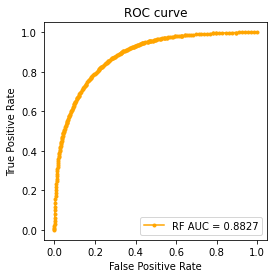

In [52]:
train_idx = df_detect_peptide_train.shape[0]
df = pd.concat([df_detect_peptide_train, df_detect_peptide_test], axis=0)
df = labelling_detect(df, aa2val, RF_digest)
train = df.iloc[:train_idx]
test = df.iloc[train_idx:]

X_train = train.drop('ID', axis=1).values
y_train = train.ID.values
X_test = test.drop('ID', axis=1).values
y_test = test.ID.values
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

RF_detect = RandomForestClassifier(n_estimators=200, max_features='sqrt')
RF_detect.fit(X_train, y_train)

# prediction
y_pred = RF_detect.predict(X_test)
print(classification_report(y_test, y_pred))

# AUC
probs = RF_detect.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Loop compare

*********************THRESHOLD 0.1*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.81      0.23      0.36      4894
           1       0.95      1.00      0.97     66673

    accuracy                           0.94     71567
   macro avg       0.88      0.61      0.67     71567
weighted avg       0.94      0.94      0.93     71567

AUC : 0.9074231720973839
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8821683082424043


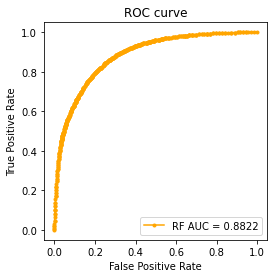

*********************THRESHOLD 0.2*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.79      0.30      0.43      6032
           1       0.94      0.99      0.97     65535

    accuracy                           0.93     71567
   macro avg       0.86      0.64      0.70     71567
weighted avg       0.93      0.93      0.92     71567

AUC : 0.9073133580290687
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8817124304679496


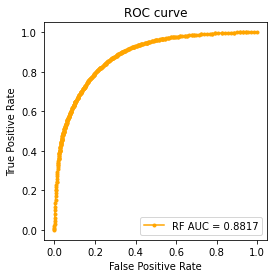

*********************THRESHOLD 0.3*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.78      0.33      0.47      7423
           1       0.93      0.99      0.96     64144

    accuracy                           0.92     71567
   macro avg       0.86      0.66      0.71     71567
weighted avg       0.91      0.92      0.91     71567

AUC : 0.905443085512467
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8818924283912384


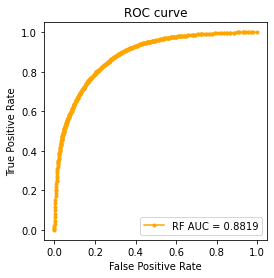

*********************THRESHOLD 0.4*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.79      0.34      0.48      9095
           1       0.91      0.99      0.95     62472

    accuracy                           0.90     71567
   macro avg       0.85      0.67      0.71     71567
weighted avg       0.90      0.90      0.89     71567

AUC : 0.8969161617059748
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8818223666882228


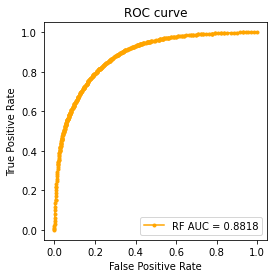

*********************THRESHOLD 0.5*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.79      0.36      0.50     11287
           1       0.89      0.98      0.93     60280

    accuracy                           0.88     71567
   macro avg       0.84      0.67      0.72     71567
weighted avg       0.87      0.88      0.87     71567

AUC : 0.8846588737511472
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.79     67298
   macro avg       0.79      0.79      0.79     67298
weighted avg       0.79      0.79      0.79     67298

rf auc : 0.8817461870889316


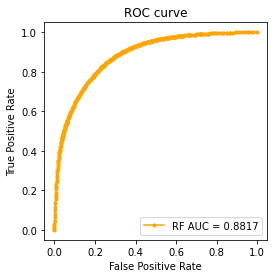

*********************THRESHOLD 0.6*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.81      0.39      0.52     16513
           1       0.84      0.97      0.90     55054

    accuracy                           0.84     71567
   macro avg       0.82      0.68      0.71     71567
weighted avg       0.83      0.84      0.81     71567

AUC : 0.8576364235185234
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.79     67298
   macro avg       0.79      0.79      0.79     67298
weighted avg       0.79      0.79      0.79     67298

rf auc : 0.8817679106107646


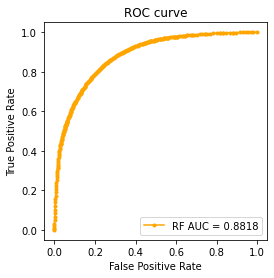

*********************THRESHOLD 0.7*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.79      0.44      0.56     20278
           1       0.81      0.96      0.88     51289

    accuracy                           0.81     71567
   macro avg       0.80      0.70      0.72     71567
weighted avg       0.81      0.81      0.79     71567

AUC : 0.8460467244004741
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8824294117887288


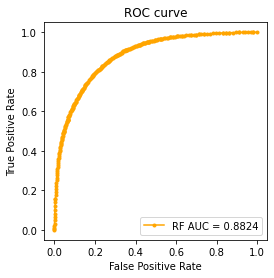

*********************THRESHOLD 0.8*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.78      0.50      0.61     24336
           1       0.78      0.93      0.85     47231

    accuracy                           0.78     71567
   macro avg       0.78      0.71      0.73     71567
weighted avg       0.78      0.78      0.77     71567

AUC : 0.8348553968234877
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8824873167452043


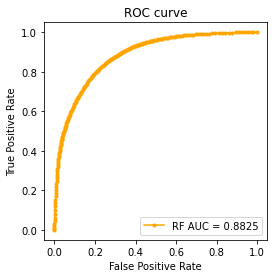

*********************THRESHOLD 0.85*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.77      0.55      0.64     26995
           1       0.77      0.90      0.83     44572

    accuracy                           0.77     71567
   macro avg       0.77      0.72      0.73     71567
weighted avg       0.77      0.77      0.76     71567

AUC : 0.8276823984325941
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8827006539795306


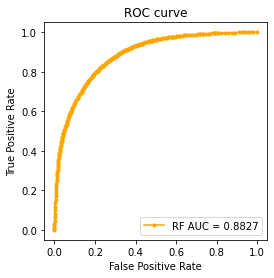

*********************THRESHOLD 0.9*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.76      0.61      0.68     30085
           1       0.75      0.86      0.80     41482

    accuracy                           0.75     71567
   macro avg       0.75      0.73      0.74     71567
weighted avg       0.75      0.75      0.75     71567

AUC : 0.8200166416934959
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8829130033595208


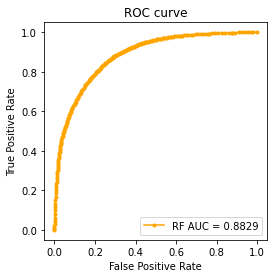

*********************THRESHOLD 0.95*******************
(286267, 315) (286267,) (214700, 315) (71567, 315) (214700,) (71567,)
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     34364
           1       0.73      0.78      0.75     37203

    accuracy                           0.73     71567
   macro avg       0.74      0.73      0.73     71567
weighted avg       0.74      0.73      0.73     71567

AUC : 0.8067329696311774
(269190, 42) (67298, 42) (269190,) (67298,)
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     33706
           1       0.79      0.81      0.80     33592

    accuracy                           0.80     67298
   macro avg       0.80      0.80      0.80     67298
weighted avg       0.80      0.80      0.80     67298

rf auc : 0.8825127284920768


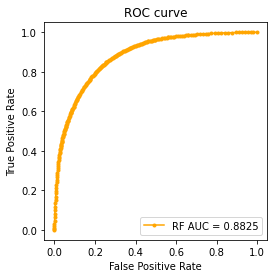

In [53]:
for THRES in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]:
    print('*********************THRESHOLD {}*******************'.format(THRES))
    df_digest = pd.DataFrame({'tryptic_site':list(ts2label.keys()), 'label':label_y(list(ts2label.values()), THRES)})
    X = np.array([[__ for _ in ts for __ in onehot_enc(_)] for ts in df_digest.tryptic_site.values])
    y = df_digest.label.values
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25, random_state=77)
    print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
    RF_digest.fit(X_train, y_train)
    y_pred = RF_digest.predict(X_test)
    print(classification_report(y_test, y_pred))
    probs = RF_digest.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, probs)
    print('AUC : {}'.format(rf_auc))
    RF_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
    RF_digest.fit(X, y)  # for adjusting Detectability

    train_idx = df_detect_peptide_train.shape[0]
    df = pd.concat([df_detect_peptide_train, df_detect_peptide_test], axis=0)
    df = labelling_detect(df, aa2val, RF_digest)
    train = df.iloc[:train_idx]
    test = df.iloc[train_idx:]

    X_train = train.drop('ID', axis=1).values
    y_train = train.ID.values
    X_test = test.drop('ID', axis=1).values
    y_test = test.ID.values
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    RF_detect = RandomForestClassifier(n_estimators=200, max_features='sqrt')
    RF_detect.fit(X_train, y_train)

    # prediction
    y_pred = RF_detect.predict(X_test)
    print(classification_report(y_test, y_pred))

    # AUC
    probs = RF_detect.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, probs)
    print('rf auc : {}'.format(rf_auc))
    # plot the roc curve for the model
    rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(4, 4))
    plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
    plt.title('ROC curve')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()